# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

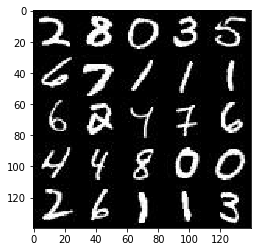

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

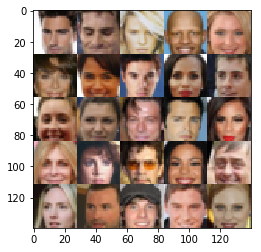

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests


def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(
        dtype=tf.float32,
        shape=(None, image_width, image_height, image_channels),
        name='input_real')
    
    z_input = tf.placeholder(
        dtype=tf.float32, shape=(None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28X28X3
        x1 = tf.layers.conv2d(images, 32, 3, strides=2, padding='same')
        nor1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * nor1, nor1)
        # 14X14X32
        
        x1_ = tf.layers.conv2d(relu1, 64, 3, strides=1, padding='same')
        nor2_ = tf.layers.batch_normalization(x1_, training=True)
        relu2_ = tf.maximum(alpha * nor2_, nor2_)
        # 14X14X64
        
        x2 = tf.layers.conv2d(relu2_, 128, 3, strides=2, padding='same')
        nor2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * nor2, nor2)
        # 7X7X64
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        nor3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * nor3, nor3)
        # 4 X 4 X 128, because the ceil will max the 3.5 to 4 in output height calculation
        
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        nor4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * nor4, nor4)
        # 2X2X256
        
        flat = tf.reshape(relu4, (-1, 2 * 2* 512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    
    1. The z comes as noise vector. And that need to be passed in to fully connected layer.
    2. reshape the vector in to multi dim matrix.
    
    output = input * stride + max(filter - stride, 0)  # VALID
    output = input * stride  # SAME
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 3*3*512)
        
        x = tf.reshape(x, (-1, 3, 3, 512))
        nor = tf.layers.batch_normalization(x, training=is_train)
        relu = tf.maximum(alpha * nor, nor)
        
        x1_ = tf.layers.conv2d_transpose(relu, 256, 3, strides=2, padding='valid')
        nor1_ = tf.layers.batch_normalization(x1_, training=is_train)
        relu1_ = tf.maximum(alpha * nor1_, nor1_)
        # 7, 7, 256
        
        # Having a addtional layer with same size.
        x1 = tf.layers.conv2d_transpose(relu1_, 128, 3, strides=1, padding='same')
        nor1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * nor1, nor1)
        # 7, 7, 128        
        
        x2 = tf.layers.conv2d_transpose(relu1, 64, 3, strides=2, padding='same')
        nor2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * nor2, nor2)
        # 14, 14, 64
        
        x3 = tf.layers.conv2d_transpose(relu2, 32, 3, strides=2, padding='same')
        nor3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * nor3, nor3)
        # 28, 28, 32
            
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_real_model, d_real_logits = discriminator(input_real)
    # Use the same weights in for discriminator
    d_noise_model, d_noise_logits = discriminator(g_model, reuse=True)

    d_real_lose = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_real_logits, labels=tf.ones_like(d_real_logits) * 0.9))

    d_noise_lose = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_noise_logits, labels=tf.zeros_like(d_noise_logits)))

    d_total_lose = d_real_lose + d_noise_lose

    # logits from discriminator.
    g_lose = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_noise_logits, labels=tf.ones_like(d_noise_logits)))

    return d_total_lose, g_lose


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Discriminator Loss: 0.4403... Generator Loss: 11.1866
Epoch 1/5... Discriminator Loss: 0.4686... Generator Loss: 16.1964
Epoch 1/5... Discriminator Loss: 0.8604... Generator Loss: 1.5583
Epoch 1/5... Discriminator Loss: 1.0408... Generator Loss: 1.3436
Epoch 1/5... Discriminator Loss: 1.5284... Generator Loss: 0.4114
Epoch 1/5... Discriminator Loss: 0.7778... Generator Loss: 2.1561
Epoch 1/5... Discriminator Loss: 0.9079... Generator Loss: 1.2612
Epoch 1/5... Discriminator Loss: 0.6015... Generator Loss: 2.2953
Epoch 1/5... Discriminator Loss: 1.0888... Generator Loss: 0.7750
Epoch 1/5... Discriminator Loss: 0.9797... Generator Loss: 1.4532


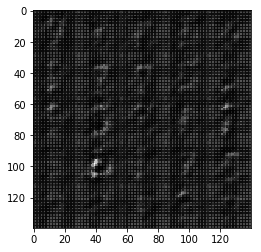

Epoch 1/5... Discriminator Loss: 0.8620... Generator Loss: 1.4085
Epoch 1/5... Discriminator Loss: 0.7956... Generator Loss: 1.1868
Epoch 1/5... Discriminator Loss: 1.2278... Generator Loss: 0.6887
Epoch 1/5... Discriminator Loss: 0.7702... Generator Loss: 1.6676
Epoch 1/5... Discriminator Loss: 0.9857... Generator Loss: 0.8861
Epoch 1/5... Discriminator Loss: 0.9456... Generator Loss: 1.1168
Epoch 1/5... Discriminator Loss: 1.0364... Generator Loss: 0.9954
Epoch 1/5... Discriminator Loss: 0.9275... Generator Loss: 1.8432
Epoch 1/5... Discriminator Loss: 0.8629... Generator Loss: 1.2453
Epoch 1/5... Discriminator Loss: 1.7377... Generator Loss: 0.3239


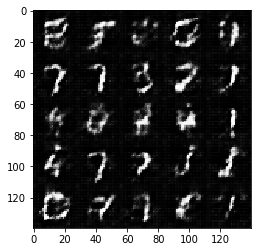

Epoch 1/5... Discriminator Loss: 0.9746... Generator Loss: 1.0961
Epoch 1/5... Discriminator Loss: 0.9289... Generator Loss: 1.0810
Epoch 1/5... Discriminator Loss: 0.8894... Generator Loss: 1.1403
Epoch 1/5... Discriminator Loss: 0.8395... Generator Loss: 1.4135
Epoch 1/5... Discriminator Loss: 0.8429... Generator Loss: 1.2087
Epoch 1/5... Discriminator Loss: 0.9935... Generator Loss: 1.9370
Epoch 1/5... Discriminator Loss: 1.0440... Generator Loss: 0.8629
Epoch 1/5... Discriminator Loss: 1.1003... Generator Loss: 1.2042
Epoch 1/5... Discriminator Loss: 1.0947... Generator Loss: 0.7734
Epoch 1/5... Discriminator Loss: 0.9224... Generator Loss: 1.1884


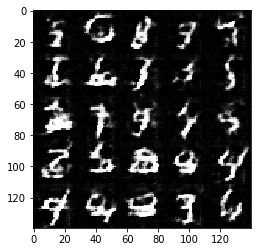

Epoch 1/5... Discriminator Loss: 0.9053... Generator Loss: 1.1951
Epoch 1/5... Discriminator Loss: 0.9281... Generator Loss: 1.5824
Epoch 1/5... Discriminator Loss: 1.4427... Generator Loss: 0.4688
Epoch 1/5... Discriminator Loss: 0.9661... Generator Loss: 1.9201
Epoch 1/5... Discriminator Loss: 0.8948... Generator Loss: 1.3505
Epoch 1/5... Discriminator Loss: 1.3628... Generator Loss: 2.6078
Epoch 1/5... Discriminator Loss: 1.8873... Generator Loss: 0.3107
Epoch 1/5... Discriminator Loss: 1.0332... Generator Loss: 0.9670
Epoch 1/5... Discriminator Loss: 1.6421... Generator Loss: 0.3557
Epoch 1/5... Discriminator Loss: 1.0829... Generator Loss: 1.0933


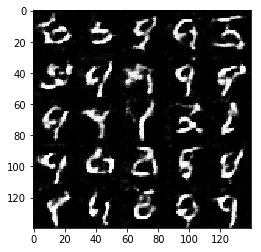

Epoch 1/5... Discriminator Loss: 1.1205... Generator Loss: 0.8491
Epoch 1/5... Discriminator Loss: 1.5188... Generator Loss: 0.4177
Epoch 1/5... Discriminator Loss: 1.2856... Generator Loss: 0.5499
Epoch 1/5... Discriminator Loss: 0.9159... Generator Loss: 1.3279
Epoch 1/5... Discriminator Loss: 1.0419... Generator Loss: 0.8260
Epoch 1/5... Discriminator Loss: 0.8826... Generator Loss: 1.3070
Epoch 1/5... Discriminator Loss: 1.1055... Generator Loss: 1.9729
Epoch 1/5... Discriminator Loss: 1.5296... Generator Loss: 0.4353
Epoch 1/5... Discriminator Loss: 1.0548... Generator Loss: 1.1762
Epoch 1/5... Discriminator Loss: 0.9780... Generator Loss: 1.1303


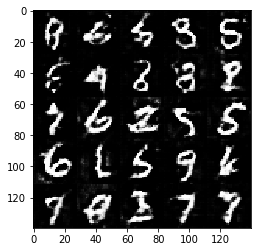

Epoch 1/5... Discriminator Loss: 1.2765... Generator Loss: 0.5525
Epoch 1/5... Discriminator Loss: 0.9911... Generator Loss: 1.8940
Epoch 1/5... Discriminator Loss: 1.2624... Generator Loss: 0.5629
Epoch 1/5... Discriminator Loss: 1.0295... Generator Loss: 0.9369
Epoch 1/5... Discriminator Loss: 1.2713... Generator Loss: 0.5813
Epoch 1/5... Discriminator Loss: 1.4053... Generator Loss: 0.4778
Epoch 1/5... Discriminator Loss: 1.0275... Generator Loss: 1.0898
Epoch 1/5... Discriminator Loss: 0.8064... Generator Loss: 1.2654
Epoch 1/5... Discriminator Loss: 1.0747... Generator Loss: 0.9897
Epoch 1/5... Discriminator Loss: 1.0589... Generator Loss: 2.0700


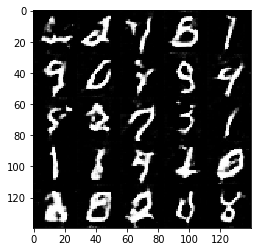

Epoch 1/5... Discriminator Loss: 0.8135... Generator Loss: 1.2674
Epoch 1/5... Discriminator Loss: 1.3577... Generator Loss: 0.5254
Epoch 1/5... Discriminator Loss: 1.3548... Generator Loss: 0.6445
Epoch 1/5... Discriminator Loss: 0.8660... Generator Loss: 1.3089
Epoch 1/5... Discriminator Loss: 0.7909... Generator Loss: 1.1969
Epoch 1/5... Discriminator Loss: 0.7970... Generator Loss: 1.1751
Epoch 1/5... Discriminator Loss: 1.5129... Generator Loss: 0.4582
Epoch 1/5... Discriminator Loss: 2.7199... Generator Loss: 0.1425
Epoch 1/5... Discriminator Loss: 1.3939... Generator Loss: 0.5412
Epoch 1/5... Discriminator Loss: 1.1482... Generator Loss: 0.6753


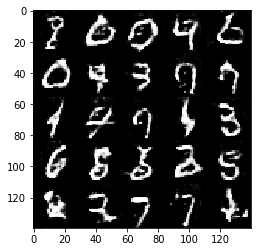

Epoch 1/5... Discriminator Loss: 1.4853... Generator Loss: 0.5143
Epoch 1/5... Discriminator Loss: 0.9079... Generator Loss: 0.9035
Epoch 1/5... Discriminator Loss: 1.0049... Generator Loss: 0.8933
Epoch 1/5... Discriminator Loss: 1.1167... Generator Loss: 0.8905
Epoch 1/5... Discriminator Loss: 1.2653... Generator Loss: 0.5554
Epoch 1/5... Discriminator Loss: 0.9932... Generator Loss: 0.8373
Epoch 1/5... Discriminator Loss: 0.9797... Generator Loss: 0.8903
Epoch 1/5... Discriminator Loss: 0.9649... Generator Loss: 0.8631
Epoch 1/5... Discriminator Loss: 0.7646... Generator Loss: 1.2602
Epoch 1/5... Discriminator Loss: 1.6636... Generator Loss: 0.4184


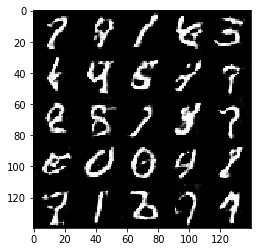

Epoch 1/5... Discriminator Loss: 0.9012... Generator Loss: 1.8644
Epoch 1/5... Discriminator Loss: 1.1640... Generator Loss: 0.6875
Epoch 1/5... Discriminator Loss: 0.8133... Generator Loss: 1.1438
Epoch 1/5... Discriminator Loss: 0.8277... Generator Loss: 1.1126
Epoch 1/5... Discriminator Loss: 0.7834... Generator Loss: 1.5752
Epoch 1/5... Discriminator Loss: 1.3680... Generator Loss: 0.6618
Epoch 1/5... Discriminator Loss: 0.7608... Generator Loss: 1.2957
Epoch 1/5... Discriminator Loss: 0.7641... Generator Loss: 1.2050
Epoch 1/5... Discriminator Loss: 0.7556... Generator Loss: 1.1989
Epoch 1/5... Discriminator Loss: 1.2742... Generator Loss: 0.5850


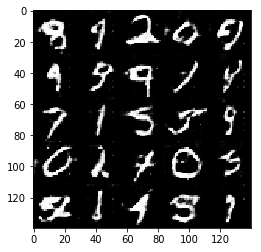

Epoch 1/5... Discriminator Loss: 0.9881... Generator Loss: 0.8321
Epoch 1/5... Discriminator Loss: 0.6677... Generator Loss: 1.4643
Epoch 1/5... Discriminator Loss: 0.7936... Generator Loss: 1.4716
Epoch 2/5... Discriminator Loss: 0.6494... Generator Loss: 1.5414
Epoch 2/5... Discriminator Loss: 0.8581... Generator Loss: 1.0057
Epoch 2/5... Discriminator Loss: 0.8277... Generator Loss: 1.0833
Epoch 2/5... Discriminator Loss: 1.1924... Generator Loss: 0.6043
Epoch 2/5... Discriminator Loss: 0.7966... Generator Loss: 1.0698
Epoch 2/5... Discriminator Loss: 0.4712... Generator Loss: 2.3576
Epoch 2/5... Discriminator Loss: 0.6577... Generator Loss: 1.3779


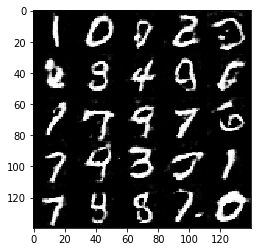

Epoch 2/5... Discriminator Loss: 0.7880... Generator Loss: 1.2150
Epoch 2/5... Discriminator Loss: 1.3083... Generator Loss: 0.5721
Epoch 2/5... Discriminator Loss: 1.2711... Generator Loss: 3.9875
Epoch 2/5... Discriminator Loss: 0.6824... Generator Loss: 1.4885
Epoch 2/5... Discriminator Loss: 0.5193... Generator Loss: 1.9285
Epoch 2/5... Discriminator Loss: 0.5895... Generator Loss: 1.6590
Epoch 2/5... Discriminator Loss: 0.5636... Generator Loss: 2.0320
Epoch 2/5... Discriminator Loss: 0.6499... Generator Loss: 1.4328
Epoch 2/5... Discriminator Loss: 0.4626... Generator Loss: 2.2343
Epoch 2/5... Discriminator Loss: 0.8206... Generator Loss: 1.1504


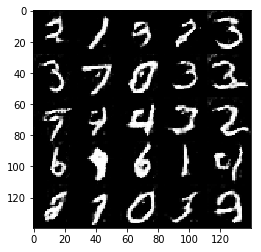

Epoch 2/5... Discriminator Loss: 0.6591... Generator Loss: 1.4004
Epoch 2/5... Discriminator Loss: 0.7061... Generator Loss: 1.2380
Epoch 2/5... Discriminator Loss: 1.4898... Generator Loss: 0.5821
Epoch 2/5... Discriminator Loss: 1.3223... Generator Loss: 0.6209
Epoch 2/5... Discriminator Loss: 0.8010... Generator Loss: 1.1115
Epoch 2/5... Discriminator Loss: 0.8558... Generator Loss: 1.1070
Epoch 2/5... Discriminator Loss: 1.1947... Generator Loss: 0.6392
Epoch 2/5... Discriminator Loss: 0.5877... Generator Loss: 1.8155
Epoch 2/5... Discriminator Loss: 1.4875... Generator Loss: 0.6571
Epoch 2/5... Discriminator Loss: 0.8536... Generator Loss: 0.9699


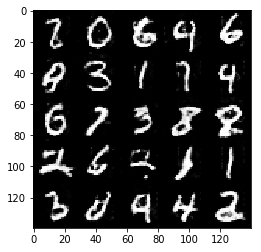

Epoch 2/5... Discriminator Loss: 0.9280... Generator Loss: 0.8677
Epoch 2/5... Discriminator Loss: 0.6210... Generator Loss: 1.7684
Epoch 2/5... Discriminator Loss: 0.5892... Generator Loss: 1.7012
Epoch 2/5... Discriminator Loss: 0.5494... Generator Loss: 2.2039
Epoch 2/5... Discriminator Loss: 0.5491... Generator Loss: 1.7718
Epoch 2/5... Discriminator Loss: 0.7386... Generator Loss: 1.1998
Epoch 2/5... Discriminator Loss: 1.1855... Generator Loss: 0.6341
Epoch 2/5... Discriminator Loss: 0.7553... Generator Loss: 1.2031
Epoch 2/5... Discriminator Loss: 0.5199... Generator Loss: 2.4238
Epoch 2/5... Discriminator Loss: 0.6337... Generator Loss: 1.5259


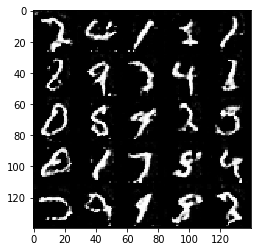

Epoch 2/5... Discriminator Loss: 0.5625... Generator Loss: 2.6415
Epoch 2/5... Discriminator Loss: 0.6345... Generator Loss: 1.6271
Epoch 2/5... Discriminator Loss: 0.9860... Generator Loss: 0.8992
Epoch 2/5... Discriminator Loss: 0.8725... Generator Loss: 1.0292
Epoch 2/5... Discriminator Loss: 1.1921... Generator Loss: 0.7809
Epoch 2/5... Discriminator Loss: 0.5942... Generator Loss: 1.8340
Epoch 2/5... Discriminator Loss: 0.7537... Generator Loss: 1.1725
Epoch 2/5... Discriminator Loss: 0.7826... Generator Loss: 1.0891
Epoch 2/5... Discriminator Loss: 0.6883... Generator Loss: 1.5218
Epoch 2/5... Discriminator Loss: 0.6402... Generator Loss: 1.5460


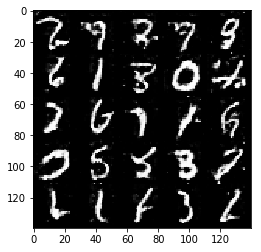

Epoch 2/5... Discriminator Loss: 1.2385... Generator Loss: 0.5860
Epoch 2/5... Discriminator Loss: 1.1386... Generator Loss: 0.7181
Epoch 2/5... Discriminator Loss: 1.0446... Generator Loss: 2.6086
Epoch 2/5... Discriminator Loss: 0.8979... Generator Loss: 0.9177
Epoch 2/5... Discriminator Loss: 0.8028... Generator Loss: 1.2060
Epoch 2/5... Discriminator Loss: 1.2643... Generator Loss: 0.6334
Epoch 2/5... Discriminator Loss: 0.6735... Generator Loss: 1.4475
Epoch 2/5... Discriminator Loss: 0.6090... Generator Loss: 1.7642
Epoch 2/5... Discriminator Loss: 0.6442... Generator Loss: 1.4485
Epoch 2/5... Discriminator Loss: 0.6562... Generator Loss: 1.4399


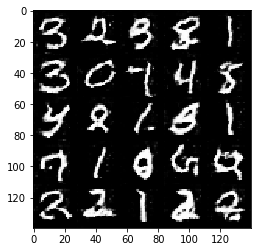

Epoch 2/5... Discriminator Loss: 0.4970... Generator Loss: 2.2721
Epoch 2/5... Discriminator Loss: 0.5486... Generator Loss: 1.8400
Epoch 2/5... Discriminator Loss: 1.0162... Generator Loss: 0.9147
Epoch 2/5... Discriminator Loss: 0.5166... Generator Loss: 1.9046
Epoch 2/5... Discriminator Loss: 2.2892... Generator Loss: 0.2928
Epoch 2/5... Discriminator Loss: 0.5835... Generator Loss: 1.7559
Epoch 2/5... Discriminator Loss: 0.5682... Generator Loss: 2.4162
Epoch 2/5... Discriminator Loss: 0.5436... Generator Loss: 1.7549
Epoch 2/5... Discriminator Loss: 0.5941... Generator Loss: 1.5813
Epoch 2/5... Discriminator Loss: 1.2116... Generator Loss: 0.6483


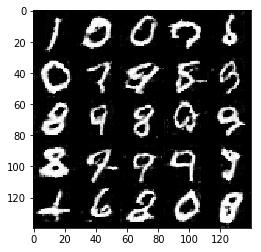

Epoch 2/5... Discriminator Loss: 2.4174... Generator Loss: 0.2116
Epoch 2/5... Discriminator Loss: 0.6639... Generator Loss: 1.3955
Epoch 2/5... Discriminator Loss: 1.3656... Generator Loss: 0.5542
Epoch 2/5... Discriminator Loss: 0.6880... Generator Loss: 1.3323
Epoch 2/5... Discriminator Loss: 0.6746... Generator Loss: 1.3816
Epoch 2/5... Discriminator Loss: 0.4651... Generator Loss: 2.5013
Epoch 2/5... Discriminator Loss: 1.4698... Generator Loss: 0.5059
Epoch 2/5... Discriminator Loss: 0.6265... Generator Loss: 1.4793
Epoch 2/5... Discriminator Loss: 0.8635... Generator Loss: 1.3196
Epoch 2/5... Discriminator Loss: 0.6306... Generator Loss: 1.6673


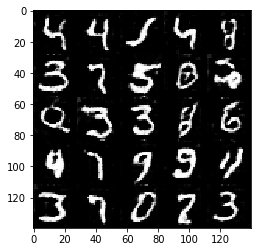

Epoch 2/5... Discriminator Loss: 0.4648... Generator Loss: 2.1894
Epoch 2/5... Discriminator Loss: 0.4296... Generator Loss: 3.0557
Epoch 2/5... Discriminator Loss: 0.6466... Generator Loss: 1.4786
Epoch 2/5... Discriminator Loss: 0.5912... Generator Loss: 1.5921
Epoch 2/5... Discriminator Loss: 0.5227... Generator Loss: 1.8933
Epoch 2/5... Discriminator Loss: 0.5999... Generator Loss: 1.6423
Epoch 2/5... Discriminator Loss: 1.5179... Generator Loss: 0.6064
Epoch 2/5... Discriminator Loss: 0.8928... Generator Loss: 1.0457
Epoch 2/5... Discriminator Loss: 0.5217... Generator Loss: 2.6260
Epoch 2/5... Discriminator Loss: 0.6585... Generator Loss: 1.9941


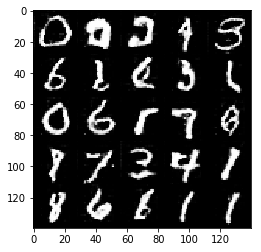

Epoch 2/5... Discriminator Loss: 0.6609... Generator Loss: 1.4466
Epoch 2/5... Discriminator Loss: 0.6351... Generator Loss: 1.5631
Epoch 2/5... Discriminator Loss: 0.4813... Generator Loss: 2.0916
Epoch 2/5... Discriminator Loss: 0.5557... Generator Loss: 1.8556
Epoch 2/5... Discriminator Loss: 0.6507... Generator Loss: 1.3874
Epoch 2/5... Discriminator Loss: 0.6051... Generator Loss: 2.0938
Epoch 2/5... Discriminator Loss: 0.6096... Generator Loss: 1.5753
Epoch 3/5... Discriminator Loss: 0.6892... Generator Loss: 1.3283
Epoch 3/5... Discriminator Loss: 0.6909... Generator Loss: 1.3693
Epoch 3/5... Discriminator Loss: 0.4629... Generator Loss: 2.4140


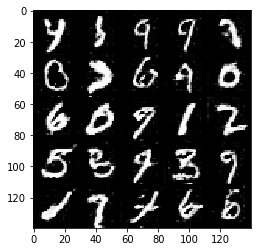

Epoch 3/5... Discriminator Loss: 0.8135... Generator Loss: 1.1301
Epoch 3/5... Discriminator Loss: 0.8528... Generator Loss: 1.2116
Epoch 3/5... Discriminator Loss: 1.7107... Generator Loss: 5.1096
Epoch 3/5... Discriminator Loss: 0.6007... Generator Loss: 1.6473
Epoch 3/5... Discriminator Loss: 0.5716... Generator Loss: 1.7297
Epoch 3/5... Discriminator Loss: 0.6328... Generator Loss: 1.4962
Epoch 3/5... Discriminator Loss: 0.4445... Generator Loss: 2.5892
Epoch 3/5... Discriminator Loss: 0.4165... Generator Loss: 3.4744
Epoch 3/5... Discriminator Loss: 1.0055... Generator Loss: 1.0491
Epoch 3/5... Discriminator Loss: 0.5357... Generator Loss: 1.9417


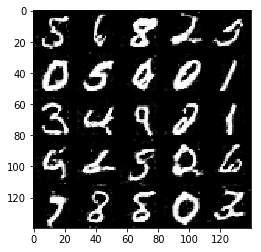

Epoch 3/5... Discriminator Loss: 0.4799... Generator Loss: 2.0878
Epoch 3/5... Discriminator Loss: 0.6750... Generator Loss: 1.3852
Epoch 3/5... Discriminator Loss: 0.5747... Generator Loss: 1.7973
Epoch 3/5... Discriminator Loss: 0.9711... Generator Loss: 0.8499
Epoch 3/5... Discriminator Loss: 0.5693... Generator Loss: 1.7035
Epoch 3/5... Discriminator Loss: 0.8140... Generator Loss: 1.0886
Epoch 3/5... Discriminator Loss: 0.8576... Generator Loss: 1.0782
Epoch 3/5... Discriminator Loss: 0.4914... Generator Loss: 2.3345
Epoch 3/5... Discriminator Loss: 0.4241... Generator Loss: 2.8905
Epoch 3/5... Discriminator Loss: 0.3895... Generator Loss: 3.0132


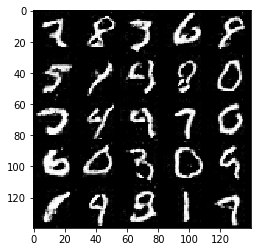

Epoch 3/5... Discriminator Loss: 0.4434... Generator Loss: 2.4885
Epoch 3/5... Discriminator Loss: 0.4880... Generator Loss: 2.0933
Epoch 3/5... Discriminator Loss: 0.3905... Generator Loss: 2.9636
Epoch 3/5... Discriminator Loss: 0.4557... Generator Loss: 2.7982
Epoch 3/5... Discriminator Loss: 0.4737... Generator Loss: 2.5762
Epoch 3/5... Discriminator Loss: 0.7991... Generator Loss: 1.0870
Epoch 3/5... Discriminator Loss: 0.4969... Generator Loss: 2.2322
Epoch 3/5... Discriminator Loss: 0.4996... Generator Loss: 3.9044
Epoch 3/5... Discriminator Loss: 0.3967... Generator Loss: 3.0240
Epoch 3/5... Discriminator Loss: 0.5069... Generator Loss: 2.0216


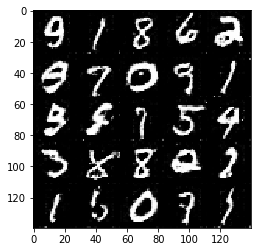

Epoch 3/5... Discriminator Loss: 0.4699... Generator Loss: 2.3160
Epoch 3/5... Discriminator Loss: 0.9836... Generator Loss: 0.8887
Epoch 3/5... Discriminator Loss: 0.5064... Generator Loss: 2.0611
Epoch 3/5... Discriminator Loss: 1.4590... Generator Loss: 0.5560
Epoch 3/5... Discriminator Loss: 0.4819... Generator Loss: 2.1762
Epoch 3/5... Discriminator Loss: 0.7876... Generator Loss: 1.2822
Epoch 3/5... Discriminator Loss: 1.0819... Generator Loss: 0.9719
Epoch 3/5... Discriminator Loss: 0.5230... Generator Loss: 2.0392
Epoch 3/5... Discriminator Loss: 0.6154... Generator Loss: 1.5410
Epoch 3/5... Discriminator Loss: 2.1494... Generator Loss: 0.2606


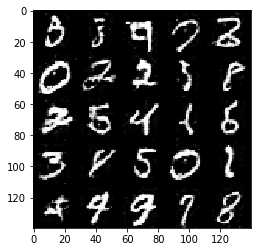

Epoch 3/5... Discriminator Loss: 0.4550... Generator Loss: 2.3291
Epoch 3/5... Discriminator Loss: 1.2237... Generator Loss: 0.7587
Epoch 3/5... Discriminator Loss: 0.5551... Generator Loss: 2.1255
Epoch 3/5... Discriminator Loss: 0.4554... Generator Loss: 2.4703
Epoch 3/5... Discriminator Loss: 1.6195... Generator Loss: 0.4521
Epoch 3/5... Discriminator Loss: 0.5875... Generator Loss: 1.7434
Epoch 3/5... Discriminator Loss: 0.9819... Generator Loss: 0.9257
Epoch 3/5... Discriminator Loss: 0.5463... Generator Loss: 1.7588
Epoch 3/5... Discriminator Loss: 0.6640... Generator Loss: 1.4473
Epoch 3/5... Discriminator Loss: 0.4799... Generator Loss: 2.1692


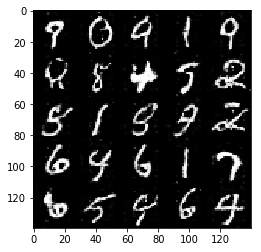

Epoch 3/5... Discriminator Loss: 0.7581... Generator Loss: 1.1325
Epoch 3/5... Discriminator Loss: 1.0156... Generator Loss: 0.9974
Epoch 3/5... Discriminator Loss: 0.9563... Generator Loss: 0.9632
Epoch 3/5... Discriminator Loss: 0.4508... Generator Loss: 2.6479
Epoch 3/5... Discriminator Loss: 0.5416... Generator Loss: 2.1980
Epoch 3/5... Discriminator Loss: 0.5138... Generator Loss: 2.6070
Epoch 3/5... Discriminator Loss: 0.4067... Generator Loss: 2.9059
Epoch 3/5... Discriminator Loss: 0.6196... Generator Loss: 1.5749
Epoch 3/5... Discriminator Loss: 0.6418... Generator Loss: 1.5924
Epoch 3/5... Discriminator Loss: 0.5146... Generator Loss: 2.2501


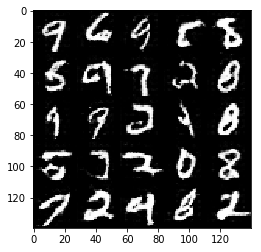

Epoch 3/5... Discriminator Loss: 1.2891... Generator Loss: 0.9474
Epoch 3/5... Discriminator Loss: 0.5211... Generator Loss: 2.1740
Epoch 3/5... Discriminator Loss: 0.5644... Generator Loss: 1.7596
Epoch 3/5... Discriminator Loss: 0.4502... Generator Loss: 2.6276
Epoch 3/5... Discriminator Loss: 0.7633... Generator Loss: 1.2895
Epoch 3/5... Discriminator Loss: 0.6535... Generator Loss: 1.4876
Epoch 3/5... Discriminator Loss: 0.5981... Generator Loss: 1.6984
Epoch 3/5... Discriminator Loss: 1.1577... Generator Loss: 0.7478
Epoch 3/5... Discriminator Loss: 1.2877... Generator Loss: 0.7289
Epoch 3/5... Discriminator Loss: 0.5290... Generator Loss: 1.8796


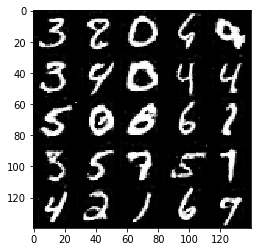

Epoch 3/5... Discriminator Loss: 0.5627... Generator Loss: 1.8847
Epoch 3/5... Discriminator Loss: 0.7452... Generator Loss: 1.2071
Epoch 3/5... Discriminator Loss: 0.7705... Generator Loss: 1.2832
Epoch 3/5... Discriminator Loss: 0.5893... Generator Loss: 1.5916
Epoch 3/5... Discriminator Loss: 0.4207... Generator Loss: 2.7918
Epoch 3/5... Discriminator Loss: 0.5828... Generator Loss: 1.8413
Epoch 3/5... Discriminator Loss: 0.6651... Generator Loss: 1.4674
Epoch 3/5... Discriminator Loss: 0.9342... Generator Loss: 0.9934
Epoch 3/5... Discriminator Loss: 1.2187... Generator Loss: 4.2085
Epoch 3/5... Discriminator Loss: 0.7989... Generator Loss: 1.1487


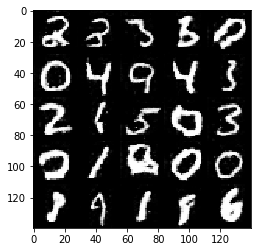

Epoch 3/5... Discriminator Loss: 0.7429... Generator Loss: 1.3352
Epoch 3/5... Discriminator Loss: 0.7432... Generator Loss: 1.2825
Epoch 3/5... Discriminator Loss: 0.5237... Generator Loss: 2.0553
Epoch 3/5... Discriminator Loss: 0.6677... Generator Loss: 1.3405
Epoch 3/5... Discriminator Loss: 0.4675... Generator Loss: 2.2180
Epoch 3/5... Discriminator Loss: 1.2969... Generator Loss: 3.8961
Epoch 3/5... Discriminator Loss: 0.6007... Generator Loss: 1.6868
Epoch 3/5... Discriminator Loss: 0.4726... Generator Loss: 2.1685
Epoch 3/5... Discriminator Loss: 0.5742... Generator Loss: 2.4652
Epoch 3/5... Discriminator Loss: 1.8138... Generator Loss: 0.3907


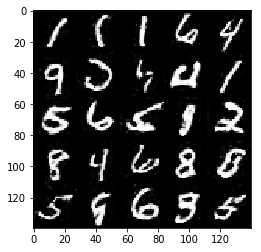

Epoch 3/5... Discriminator Loss: 0.6504... Generator Loss: 1.6939
Epoch 4/5... Discriminator Loss: 0.5149... Generator Loss: 1.9414
Epoch 4/5... Discriminator Loss: 0.6627... Generator Loss: 1.4190
Epoch 4/5... Discriminator Loss: 0.4111... Generator Loss: 3.1870
Epoch 4/5... Discriminator Loss: 0.5017... Generator Loss: 2.2915
Epoch 4/5... Discriminator Loss: 0.3807... Generator Loss: 3.7900
Epoch 4/5... Discriminator Loss: 0.6801... Generator Loss: 1.4852
Epoch 4/5... Discriminator Loss: 0.4739... Generator Loss: 2.1578
Epoch 4/5... Discriminator Loss: 1.7611... Generator Loss: 0.4801
Epoch 4/5... Discriminator Loss: 0.5818... Generator Loss: 1.6248


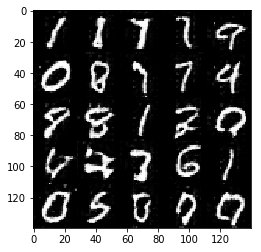

Epoch 4/5... Discriminator Loss: 0.4633... Generator Loss: 2.2517
Epoch 4/5... Discriminator Loss: 0.5484... Generator Loss: 1.7410
Epoch 4/5... Discriminator Loss: 1.1306... Generator Loss: 0.6359
Epoch 4/5... Discriminator Loss: 0.4368... Generator Loss: 2.3958
Epoch 4/5... Discriminator Loss: 0.5570... Generator Loss: 1.8058
Epoch 4/5... Discriminator Loss: 0.4090... Generator Loss: 3.0761
Epoch 4/5... Discriminator Loss: 0.4372... Generator Loss: 2.5504
Epoch 4/5... Discriminator Loss: 0.4363... Generator Loss: 2.5450
Epoch 4/5... Discriminator Loss: 0.4737... Generator Loss: 2.6562
Epoch 4/5... Discriminator Loss: 0.5328... Generator Loss: 2.1625


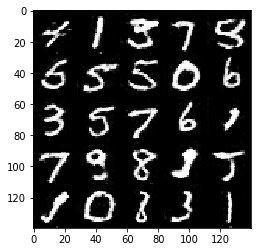

Epoch 4/5... Discriminator Loss: 2.1604... Generator Loss: 0.3541
Epoch 4/5... Discriminator Loss: 0.7666... Generator Loss: 1.1959
Epoch 4/5... Discriminator Loss: 0.5734... Generator Loss: 1.7396
Epoch 4/5... Discriminator Loss: 0.7226... Generator Loss: 1.4341
Epoch 4/5... Discriminator Loss: 0.6614... Generator Loss: 1.3973
Epoch 4/5... Discriminator Loss: 0.5592... Generator Loss: 3.5419
Epoch 4/5... Discriminator Loss: 0.6183... Generator Loss: 1.5244
Epoch 4/5... Discriminator Loss: 0.8228... Generator Loss: 1.1215
Epoch 4/5... Discriminator Loss: 1.7215... Generator Loss: 6.5329
Epoch 4/5... Discriminator Loss: 0.6150... Generator Loss: 1.5901


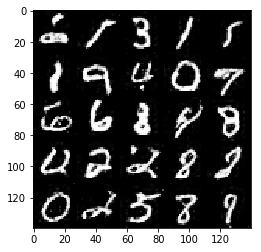

Epoch 4/5... Discriminator Loss: 1.3595... Generator Loss: 0.5765
Epoch 4/5... Discriminator Loss: 0.5747... Generator Loss: 1.6573
Epoch 4/5... Discriminator Loss: 0.8927... Generator Loss: 4.0165
Epoch 4/5... Discriminator Loss: 0.6342... Generator Loss: 2.8391
Epoch 4/5... Discriminator Loss: 0.4931... Generator Loss: 2.2912
Epoch 4/5... Discriminator Loss: 0.3938... Generator Loss: 3.0693
Epoch 4/5... Discriminator Loss: 0.4488... Generator Loss: 2.8902
Epoch 4/5... Discriminator Loss: 0.9199... Generator Loss: 1.2444
Epoch 4/5... Discriminator Loss: 0.4818... Generator Loss: 2.2859
Epoch 4/5... Discriminator Loss: 0.5537... Generator Loss: 1.8212


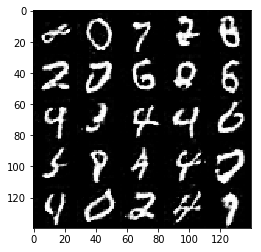

Epoch 4/5... Discriminator Loss: 2.0661... Generator Loss: 0.3568
Epoch 4/5... Discriminator Loss: 0.5527... Generator Loss: 1.8607
Epoch 4/5... Discriminator Loss: 0.4843... Generator Loss: 2.2295
Epoch 4/5... Discriminator Loss: 0.6398... Generator Loss: 3.4309
Epoch 4/5... Discriminator Loss: 0.6579... Generator Loss: 3.8311
Epoch 4/5... Discriminator Loss: 0.5920... Generator Loss: 1.5953
Epoch 4/5... Discriminator Loss: 0.5558... Generator Loss: 1.8387
Epoch 4/5... Discriminator Loss: 2.9667... Generator Loss: 0.1285
Epoch 4/5... Discriminator Loss: 0.6269... Generator Loss: 1.6731
Epoch 4/5... Discriminator Loss: 0.7435... Generator Loss: 1.1785


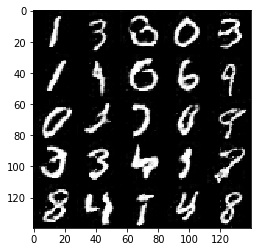

Epoch 4/5... Discriminator Loss: 0.5353... Generator Loss: 1.9890
Epoch 4/5... Discriminator Loss: 0.5907... Generator Loss: 1.5941
Epoch 4/5... Discriminator Loss: 0.5777... Generator Loss: 1.6594
Epoch 4/5... Discriminator Loss: 0.3969... Generator Loss: 3.1776
Epoch 4/5... Discriminator Loss: 0.6157... Generator Loss: 1.5971
Epoch 4/5... Discriminator Loss: 0.5439... Generator Loss: 2.7310
Epoch 4/5... Discriminator Loss: 0.5804... Generator Loss: 1.6977
Epoch 4/5... Discriminator Loss: 0.7210... Generator Loss: 1.2996
Epoch 4/5... Discriminator Loss: 0.5205... Generator Loss: 1.8736
Epoch 4/5... Discriminator Loss: 0.9055... Generator Loss: 1.0503


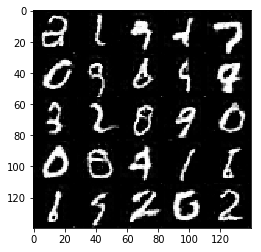

Epoch 4/5... Discriminator Loss: 0.7605... Generator Loss: 1.1613
Epoch 4/5... Discriminator Loss: 1.0560... Generator Loss: 1.0502
Epoch 4/5... Discriminator Loss: 0.6020... Generator Loss: 1.6846
Epoch 4/5... Discriminator Loss: 0.6026... Generator Loss: 1.7445
Epoch 4/5... Discriminator Loss: 1.5269... Generator Loss: 5.9819
Epoch 4/5... Discriminator Loss: 0.6174... Generator Loss: 2.6192
Epoch 4/5... Discriminator Loss: 0.6196... Generator Loss: 1.5156
Epoch 4/5... Discriminator Loss: 0.9036... Generator Loss: 3.7443
Epoch 4/5... Discriminator Loss: 0.6366... Generator Loss: 3.4818
Epoch 4/5... Discriminator Loss: 1.5106... Generator Loss: 0.5650


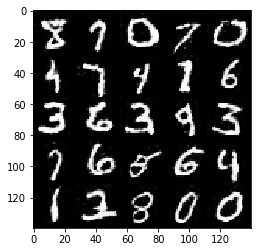

Epoch 4/5... Discriminator Loss: 0.7209... Generator Loss: 1.4244
Epoch 4/5... Discriminator Loss: 0.5798... Generator Loss: 1.6500
Epoch 4/5... Discriminator Loss: 0.6386... Generator Loss: 1.4982
Epoch 4/5... Discriminator Loss: 0.8298... Generator Loss: 1.2125
Epoch 4/5... Discriminator Loss: 0.5359... Generator Loss: 1.8009
Epoch 4/5... Discriminator Loss: 0.4842... Generator Loss: 2.3929
Epoch 4/5... Discriminator Loss: 0.4864... Generator Loss: 2.2190
Epoch 4/5... Discriminator Loss: 0.4425... Generator Loss: 2.4464
Epoch 4/5... Discriminator Loss: 0.7020... Generator Loss: 1.2927
Epoch 4/5... Discriminator Loss: 1.5076... Generator Loss: 0.7206


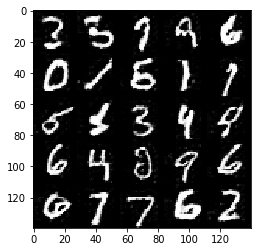

Epoch 4/5... Discriminator Loss: 0.7068... Generator Loss: 1.3740
Epoch 4/5... Discriminator Loss: 0.9888... Generator Loss: 0.8293
Epoch 4/5... Discriminator Loss: 0.5437... Generator Loss: 1.7692
Epoch 4/5... Discriminator Loss: 0.5473... Generator Loss: 1.8419
Epoch 4/5... Discriminator Loss: 0.7917... Generator Loss: 1.1501
Epoch 4/5... Discriminator Loss: 0.4831... Generator Loss: 2.1669
Epoch 4/5... Discriminator Loss: 0.9496... Generator Loss: 4.1771
Epoch 4/5... Discriminator Loss: 1.2314... Generator Loss: 0.6971
Epoch 4/5... Discriminator Loss: 0.6448... Generator Loss: 1.4019
Epoch 4/5... Discriminator Loss: 0.5448... Generator Loss: 1.7942


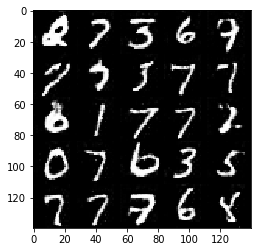

Epoch 4/5... Discriminator Loss: 0.8084... Generator Loss: 1.1190
Epoch 4/5... Discriminator Loss: 0.4136... Generator Loss: 2.6587
Epoch 4/5... Discriminator Loss: 3.5666... Generator Loss: 8.8647
Epoch 4/5... Discriminator Loss: 0.6169... Generator Loss: 1.6742
Epoch 5/5... Discriminator Loss: 0.5169... Generator Loss: 1.9137
Epoch 5/5... Discriminator Loss: 0.5761... Generator Loss: 1.6360
Epoch 5/5... Discriminator Loss: 0.6847... Generator Loss: 1.3020
Epoch 5/5... Discriminator Loss: 0.6119... Generator Loss: 2.2938
Epoch 5/5... Discriminator Loss: 0.5467... Generator Loss: 1.7536
Epoch 5/5... Discriminator Loss: 1.1448... Generator Loss: 0.7325


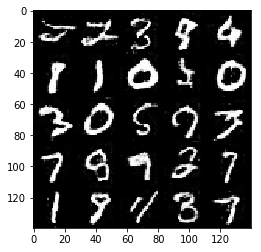

Epoch 5/5... Discriminator Loss: 0.6242... Generator Loss: 1.5518
Epoch 5/5... Discriminator Loss: 0.4608... Generator Loss: 2.2583
Epoch 5/5... Discriminator Loss: 0.8446... Generator Loss: 3.1791
Epoch 5/5... Discriminator Loss: 0.4859... Generator Loss: 2.1584
Epoch 5/5... Discriminator Loss: 0.4251... Generator Loss: 2.6311
Epoch 5/5... Discriminator Loss: 0.4474... Generator Loss: 2.5103
Epoch 5/5... Discriminator Loss: 0.5628... Generator Loss: 1.7160
Epoch 5/5... Discriminator Loss: 0.8726... Generator Loss: 0.9631
Epoch 5/5... Discriminator Loss: 0.9976... Generator Loss: 0.7938
Epoch 5/5... Discriminator Loss: 0.9573... Generator Loss: 1.0793


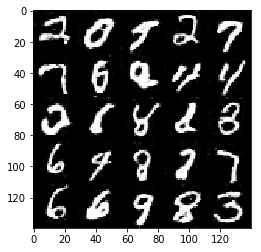

Epoch 5/5... Discriminator Loss: 0.4977... Generator Loss: 2.5500
Epoch 5/5... Discriminator Loss: 0.6080... Generator Loss: 3.3002
Epoch 5/5... Discriminator Loss: 0.5133... Generator Loss: 2.0315
Epoch 5/5... Discriminator Loss: 0.5004... Generator Loss: 2.0471
Epoch 5/5... Discriminator Loss: 0.4389... Generator Loss: 2.7883
Epoch 5/5... Discriminator Loss: 0.4360... Generator Loss: 2.5537
Epoch 5/5... Discriminator Loss: 0.5376... Generator Loss: 1.9090
Epoch 5/5... Discriminator Loss: 0.5334... Generator Loss: 1.8669
Epoch 5/5... Discriminator Loss: 0.4936... Generator Loss: 2.1649
Epoch 5/5... Discriminator Loss: 0.4714... Generator Loss: 2.1996


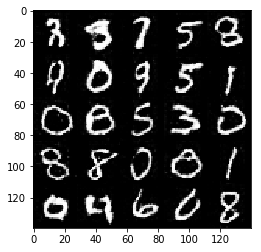

Epoch 5/5... Discriminator Loss: 0.3934... Generator Loss: 3.0172
Epoch 5/5... Discriminator Loss: 0.7389... Generator Loss: 1.5964
Epoch 5/5... Discriminator Loss: 0.4386... Generator Loss: 2.8907
Epoch 5/5... Discriminator Loss: 0.5873... Generator Loss: 1.6017
Epoch 5/5... Discriminator Loss: 0.8299... Generator Loss: 1.0691
Epoch 5/5... Discriminator Loss: 0.5043... Generator Loss: 2.2235
Epoch 5/5... Discriminator Loss: 0.5210... Generator Loss: 1.8898
Epoch 5/5... Discriminator Loss: 0.3948... Generator Loss: 3.0027
Epoch 5/5... Discriminator Loss: 0.4125... Generator Loss: 2.7299
Epoch 5/5... Discriminator Loss: 0.3756... Generator Loss: 3.2575


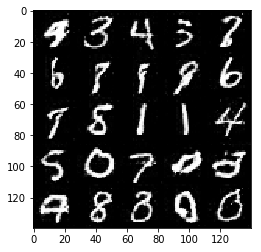

Epoch 5/5... Discriminator Loss: 0.5861... Generator Loss: 1.7612
Epoch 5/5... Discriminator Loss: 0.5883... Generator Loss: 1.6220
Epoch 5/5... Discriminator Loss: 0.8111... Generator Loss: 1.1141
Epoch 5/5... Discriminator Loss: 0.5354... Generator Loss: 1.8664
Epoch 5/5... Discriminator Loss: 0.8408... Generator Loss: 1.0558
Epoch 5/5... Discriminator Loss: 0.4400... Generator Loss: 3.7781
Epoch 5/5... Discriminator Loss: 0.5509... Generator Loss: 1.7275
Epoch 5/5... Discriminator Loss: 0.4449... Generator Loss: 3.7447
Epoch 5/5... Discriminator Loss: 0.6786... Generator Loss: 1.8353
Epoch 5/5... Discriminator Loss: 0.8348... Generator Loss: 1.1098


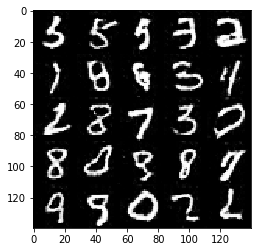

Epoch 5/5... Discriminator Loss: 0.5369... Generator Loss: 1.8408
Epoch 5/5... Discriminator Loss: 0.4666... Generator Loss: 2.4622
Epoch 5/5... Discriminator Loss: 0.9305... Generator Loss: 0.8579
Epoch 5/5... Discriminator Loss: 0.5429... Generator Loss: 2.1835
Epoch 5/5... Discriminator Loss: 0.8231... Generator Loss: 1.0755
Epoch 5/5... Discriminator Loss: 0.3665... Generator Loss: 3.8076
Epoch 5/5... Discriminator Loss: 0.4476... Generator Loss: 2.3115
Epoch 5/5... Discriminator Loss: 0.3622... Generator Loss: 4.9051
Epoch 5/5... Discriminator Loss: 1.9882... Generator Loss: 0.3875
Epoch 5/5... Discriminator Loss: 1.2954... Generator Loss: 0.6882


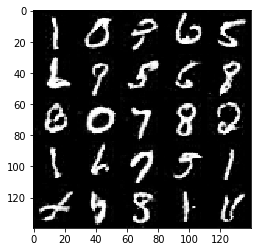

Epoch 5/5... Discriminator Loss: 0.5801... Generator Loss: 1.6348
Epoch 5/5... Discriminator Loss: 0.6001... Generator Loss: 1.6217
Epoch 5/5... Discriminator Loss: 0.5371... Generator Loss: 1.9318
Epoch 5/5... Discriminator Loss: 0.7435... Generator Loss: 1.3119
Epoch 5/5... Discriminator Loss: 0.6811... Generator Loss: 3.8897
Epoch 5/5... Discriminator Loss: 0.4674... Generator Loss: 2.1820
Epoch 5/5... Discriminator Loss: 0.6291... Generator Loss: 2.7048
Epoch 5/5... Discriminator Loss: 0.4424... Generator Loss: 2.5192
Epoch 5/5... Discriminator Loss: 0.4842... Generator Loss: 2.1183
Epoch 5/5... Discriminator Loss: 0.9738... Generator Loss: 1.1642


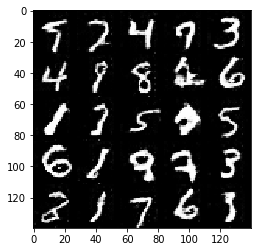

Epoch 5/5... Discriminator Loss: 0.6673... Generator Loss: 4.0426
Epoch 5/5... Discriminator Loss: 0.7705... Generator Loss: 1.4349
Epoch 5/5... Discriminator Loss: 0.4943... Generator Loss: 2.1177
Epoch 5/5... Discriminator Loss: 0.5783... Generator Loss: 1.7473
Epoch 5/5... Discriminator Loss: 0.4903... Generator Loss: 2.3103
Epoch 5/5... Discriminator Loss: 0.4911... Generator Loss: 2.1902
Epoch 5/5... Discriminator Loss: 0.5358... Generator Loss: 1.7980
Epoch 5/5... Discriminator Loss: 0.8044... Generator Loss: 1.1119
Epoch 5/5... Discriminator Loss: 0.4397... Generator Loss: 2.4979
Epoch 5/5... Discriminator Loss: 0.4499... Generator Loss: 2.6427


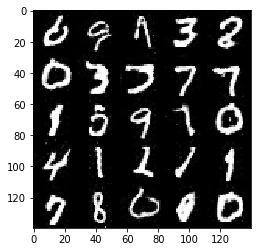

Epoch 5/5... Discriminator Loss: 0.7139... Generator Loss: 1.6187
Epoch 5/5... Discriminator Loss: 0.5407... Generator Loss: 1.7932
Epoch 5/5... Discriminator Loss: 0.3933... Generator Loss: 3.1018
Epoch 5/5... Discriminator Loss: 0.6458... Generator Loss: 1.4640
Epoch 5/5... Discriminator Loss: 0.7148... Generator Loss: 1.7870
Epoch 5/5... Discriminator Loss: 1.0230... Generator Loss: 4.6415
Epoch 5/5... Discriminator Loss: 0.5752... Generator Loss: 1.9595
Epoch 5/5... Discriminator Loss: 0.6638... Generator Loss: 1.3999
Epoch 5/5... Discriminator Loss: 1.1148... Generator Loss: 0.9313
Epoch 5/5... Discriminator Loss: 0.7844... Generator Loss: 1.2873


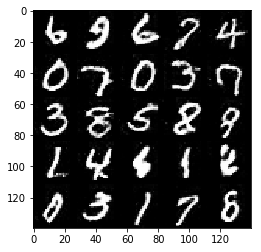

Epoch 5/5... Discriminator Loss: 1.4280... Generator Loss: 0.4986
Epoch 5/5... Discriminator Loss: 0.4916... Generator Loss: 2.1708
Epoch 5/5... Discriminator Loss: 0.7054... Generator Loss: 1.2906
Epoch 5/5... Discriminator Loss: 1.1161... Generator Loss: 0.9230
Epoch 5/5... Discriminator Loss: 1.1752... Generator Loss: 0.6156
Epoch 5/5... Discriminator Loss: 0.4850... Generator Loss: 2.1781
Epoch 5/5... Discriminator Loss: 0.4414... Generator Loss: 2.6717
Epoch 5/5... Discriminator Loss: 0.4035... Generator Loss: 2.9853


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.6850
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 2.1924
Epoch 1/2... Discriminator Loss: 0.4213... Generator Loss: 3.1010
Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 2.7853
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 2.8291
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 4.3194
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 3.1904
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 4.5771
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 3.4501
Epoch 1/2... Discriminator Loss: 0.3806... Generator Loss: 3.5643


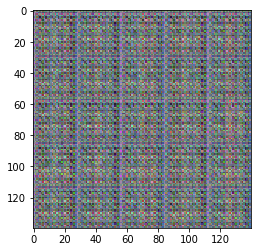

Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 4.1625
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 3.7700
Epoch 1/2... Discriminator Loss: 0.3790... Generator Loss: 3.4705
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 2.9863
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 5.0792
Epoch 1/2... Discriminator Loss: 0.3433... Generator Loss: 7.3365
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 2.5401
Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 3.8776
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 7.4995
Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 3.5080


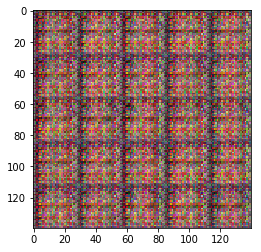

Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 3.9614
Epoch 1/2... Discriminator Loss: 0.3500... Generator Loss: 4.9558
Epoch 1/2... Discriminator Loss: 0.3517... Generator Loss: 4.4096
Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 5.4866
Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 4.3510
Epoch 1/2... Discriminator Loss: 0.3467... Generator Loss: 5.7789
Epoch 1/2... Discriminator Loss: 0.3452... Generator Loss: 5.0559
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 10.7143
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 5.8024
Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 3.3074


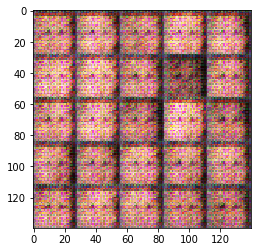

Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 3.5645
Epoch 1/2... Discriminator Loss: 0.3956... Generator Loss: 4.3678
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 8.1279
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 2.9660
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 4.2463
Epoch 1/2... Discriminator Loss: 0.4050... Generator Loss: 3.9284
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 3.7637
Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 3.0482
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 3.9175
Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 4.1771


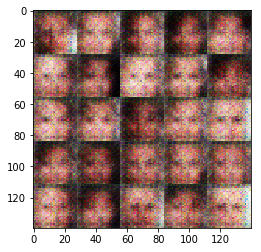

Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 2.8271
Epoch 1/2... Discriminator Loss: 0.5687... Generator Loss: 5.3853
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 2.7260
Epoch 1/2... Discriminator Loss: 0.3933... Generator Loss: 3.3292
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 4.0688
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 2.0436
Epoch 1/2... Discriminator Loss: 0.4405... Generator Loss: 3.4849
Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 2.7774
Epoch 1/2... Discriminator Loss: 0.4865... Generator Loss: 2.2428


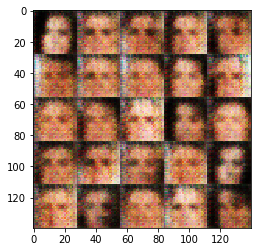

Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 5.4005
Epoch 1/2... Discriminator Loss: 0.5672... Generator Loss: 1.8063
Epoch 1/2... Discriminator Loss: 0.5814... Generator Loss: 2.9968
Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.6494
Epoch 1/2... Discriminator Loss: 0.7116... Generator Loss: 1.5321
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 2.4172
Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 2.4844
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 2.8917
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 1.7386
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 2.4578


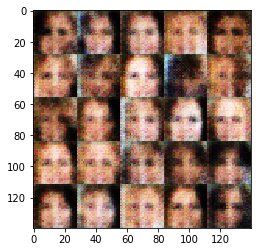

Epoch 1/2... Discriminator Loss: 0.4690... Generator Loss: 3.1388
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 1.5559
Epoch 1/2... Discriminator Loss: 0.5879... Generator Loss: 1.7320
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 3.7604
Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.8201
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.6116
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.7826
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 1.8478
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 2.2189
Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 2.2046


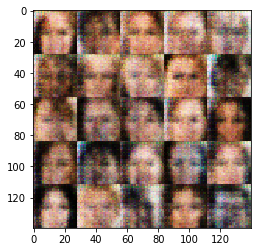

Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 2.2756
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.8452
Epoch 1/2... Discriminator Loss: 0.5730... Generator Loss: 1.7992
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 2.5601
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 2.6510
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 2.6583
Epoch 1/2... Discriminator Loss: 0.5276... Generator Loss: 3.0250
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.4101
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 4.5520
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.7124


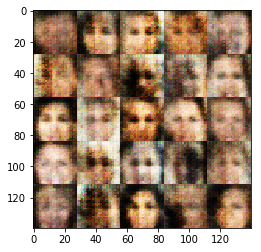

Epoch 1/2... Discriminator Loss: 0.5460... Generator Loss: 2.0152
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.7815
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.7958
Epoch 1/2... Discriminator Loss: 0.6733... Generator Loss: 2.7656
Epoch 1/2... Discriminator Loss: 0.5157... Generator Loss: 2.5571
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 3.4450
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 2.3057
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 1.4761
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 2.4333
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 2.3297


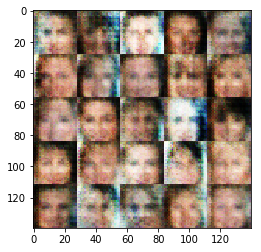

Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 0.6654... Generator Loss: 2.1529
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 3.0763
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 2.9403
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 2.9255
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 2.4289
Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 2.4847
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.6069
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 3.9845


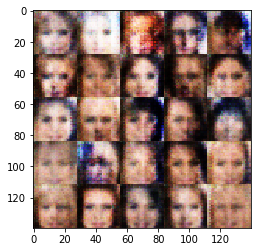

Epoch 1/2... Discriminator Loss: 0.5818... Generator Loss: 2.5800
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.9875
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 2.7775
Epoch 1/2... Discriminator Loss: 0.6451... Generator Loss: 1.6418
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 2.4750
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.7320
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 2.3228
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 3.0168
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.8548
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 2.5017


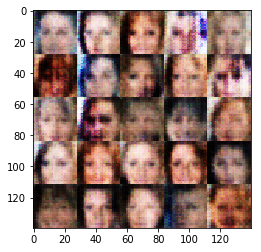

Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.5577
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 2.9104
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.8739
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 1.3355
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 2.2183
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 1.8960
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 2.2445
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 0.8652


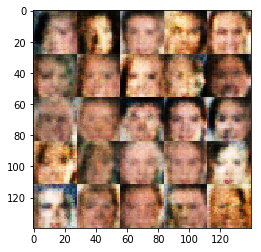

Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.9986
Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 2.4151
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 2.5134
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 2.4442
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 2.3731
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 1.5378
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 1.7331
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 2.2538


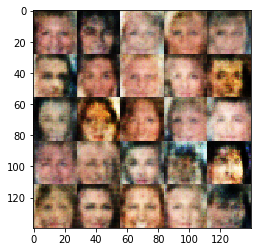

Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 2.7401
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.0898
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 2.1398
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.3622
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.7388
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.3238
Epoch 1/2... Discriminator Loss: 0.6253... Generator Loss: 1.7715
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 3.1649


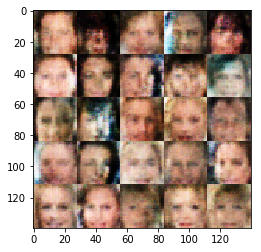

Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 1.9563
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 2.6659
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.2923
Epoch 1/2... Discriminator Loss: 0.6525... Generator Loss: 1.5760
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 3.1500
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 2.6915
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 1.6764
Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 1.7693


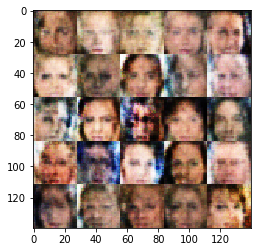

Epoch 1/2... Discriminator Loss: 0.5686... Generator Loss: 2.3639
Epoch 1/2... Discriminator Loss: 0.5094... Generator Loss: 2.7963
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.9952
Epoch 1/2... Discriminator Loss: 0.5139... Generator Loss: 2.1431
Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 2.6443
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 2.3596
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.8703
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 3.4001
Epoch 1/2... Discriminator Loss: 0.4243... Generator Loss: 2.9457


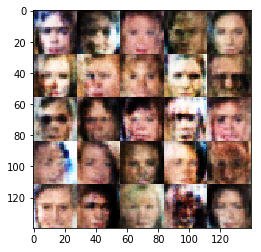

Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 1.7489
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 5.7235
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 3.5686
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 3.7056
Epoch 1/2... Discriminator Loss: 0.4854... Generator Loss: 2.8966
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 4.1042
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 3.2371
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 4.5738
Epoch 1/2... Discriminator Loss: 0.5872... Generator Loss: 1.8078


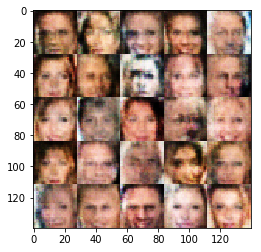

Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 3.1341
Epoch 1/2... Discriminator Loss: 0.3792... Generator Loss: 4.1838
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 1.9015
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 4.2917
Epoch 1/2... Discriminator Loss: 0.4756... Generator Loss: 2.3250
Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 3.3656
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 2.1558
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 3.2953
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 2.4719


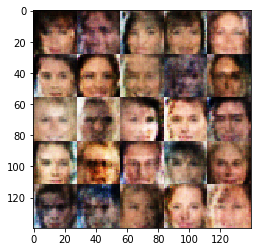

Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 4.3727
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 3.6152
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 3.7346
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 2.4390
Epoch 1/2... Discriminator Loss: 0.3968... Generator Loss: 3.9294
Epoch 1/2... Discriminator Loss: 0.4167... Generator Loss: 3.3029
Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 1.6403
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 2.1083
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 2.5445


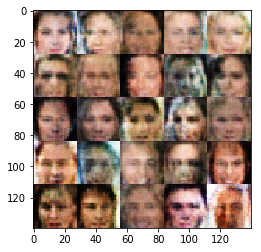

Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 1.7611
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 1.7818
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 3.0100
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 3.8425
Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 3.7950
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 3.7158
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 2.3821
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 2.9151
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 3.2432
Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 3.7840


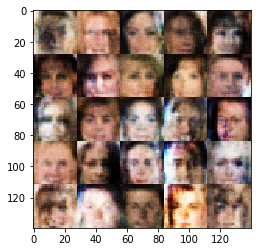

Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 2.8907
Epoch 1/2... Discriminator Loss: 0.4236... Generator Loss: 3.6024
Epoch 1/2... Discriminator Loss: 0.3958... Generator Loss: 3.3519
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 2.8228
Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 3.4756
Epoch 1/2... Discriminator Loss: 0.3882... Generator Loss: 5.2128
Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 4.2237
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.4945
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 3.6192


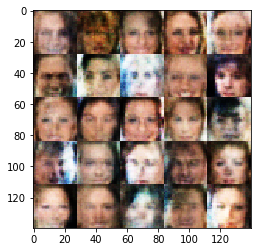

Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 3.0025
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 1.5669
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.9329
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 4.8464
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 2.7696
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 2.1972
Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 2.7781
Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 2.4995
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 3.4148
Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 2.6416


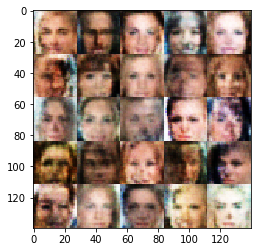

Epoch 1/2... Discriminator Loss: 0.5249... Generator Loss: 5.1278
Epoch 1/2... Discriminator Loss: 0.8336... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.1874
Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 2.8231
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 2.2502
Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 3.4974
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 3.0009
Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 2.7786
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 2.7631


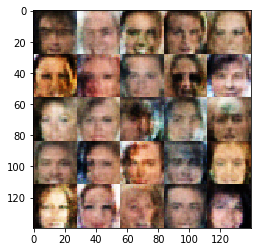

Epoch 1/2... Discriminator Loss: 0.6459... Generator Loss: 2.4424
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 2.4890
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 1.8391
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 0.5253... Generator Loss: 3.0613
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 0.7217... Generator Loss: 1.2743
Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 2.4146
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 2.0911
Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 3.5585


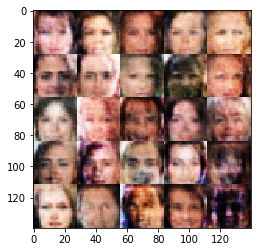

Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.6287
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 2.0840
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 2.3323
Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.5218
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 0.5207... Generator Loss: 2.3777
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.4272
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 2.2103


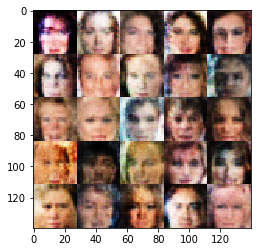

Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 3.1488
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.6338
Epoch 1/2... Discriminator Loss: 0.5201... Generator Loss: 2.3342
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 2.3862
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 2.1844
Epoch 1/2... Discriminator Loss: 0.4495... Generator Loss: 2.4675
Epoch 1/2... Discriminator Loss: 0.6896... Generator Loss: 2.3122
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 2.9422
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 1.7576
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.3470


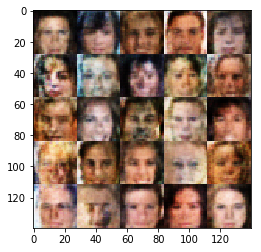

Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.0428
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 2.1520
Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 1.5629
Epoch 1/2... Discriminator Loss: 0.5068... Generator Loss: 2.2819
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.8326
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 2.3941
Epoch 1/2... Discriminator Loss: 0.4016... Generator Loss: 3.1477
Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 3.1025
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 2.9769
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 2.0724


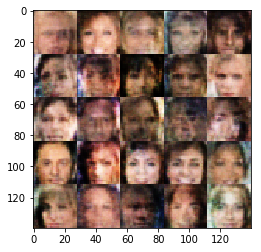

Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.9116
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 2.2123
Epoch 1/2... Discriminator Loss: 0.4913... Generator Loss: 2.3916
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 2.1930
Epoch 1/2... Discriminator Loss: 0.5687... Generator Loss: 1.8590
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 1.7296
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.3831
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 2.8024
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 1.6727


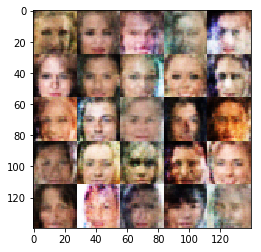

Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 0.5026... Generator Loss: 2.5213
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 3.1672
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.3119
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 2.1679
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.1619
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.6183
Epoch 1/2... Discriminator Loss: 0.5534... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 2.5970


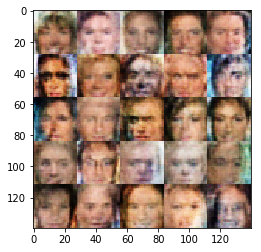

Epoch 1/2... Discriminator Loss: 0.5074... Generator Loss: 2.1588
Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 1.7524
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 1.9570
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 1.9285
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 2.3817
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 2.0118
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.0195
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.4195
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.1562


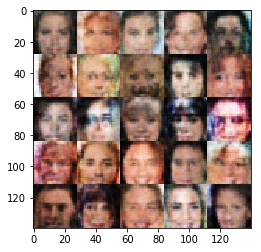

Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 2.2610
Epoch 1/2... Discriminator Loss: 0.6370... Generator Loss: 1.8403
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.3279
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.9385
Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 2.3257
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.2375
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.3735


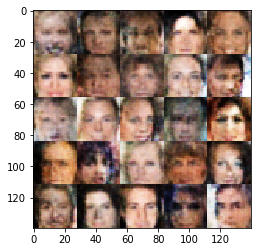

Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.6839
Epoch 1/2... Discriminator Loss: 0.5741... Generator Loss: 2.1181
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.1793
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.3807
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.8955
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 2.3160
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.2850


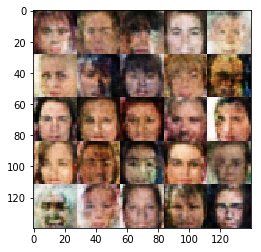

Epoch 2/2... Discriminator Loss: 0.4938... Generator Loss: 2.2845
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.4618
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 2.2212
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 2.0781
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 2.1624
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.9002


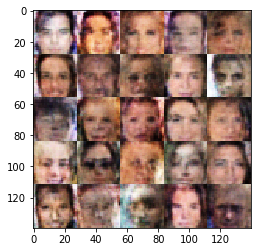

Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.6817
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.6800
Epoch 2/2... Discriminator Loss: 0.7462... Generator Loss: 1.3114
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 1.0581
Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 1.9977
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.5070
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.8977
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 2.2472
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.9459


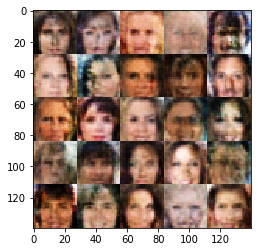

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.6366
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 2.4838
Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 1.8246
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.8204
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 2.3286
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 0.5397... Generator Loss: 2.0738
Epoch 2/2... Discriminator Loss: 0.6379... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.3842


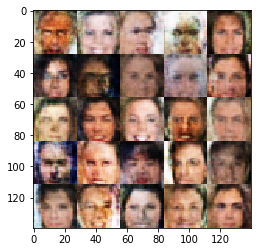

Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.8133
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 2.0051
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 2.0424
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.8972
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 2.0587
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 0.5263... Generator Loss: 1.9884
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.5736


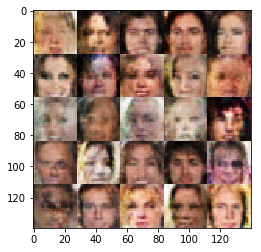

Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.3039
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 0.5758... Generator Loss: 2.4599
Epoch 2/2... Discriminator Loss: 0.5339... Generator Loss: 2.1301
Epoch 2/2... Discriminator Loss: 0.4254... Generator Loss: 2.8424
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 2.4496
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 1.7674


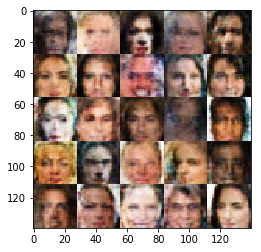

Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.7084
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 2.2063
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.4456
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 2.1111
Epoch 2/2... Discriminator Loss: 0.4988... Generator Loss: 2.3521


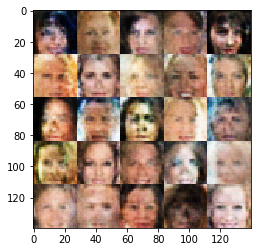

Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 2.5326
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.8348
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.5927
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.5159
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 2.0429
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 2.0424
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 2.1589


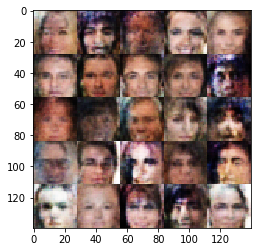

Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 1.9780
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 2.9145
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.9772
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.4422
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 2.3616
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.6224
Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 1.8093
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 2.0225


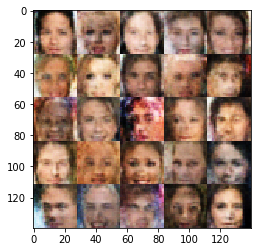

Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.2919
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.2564
Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 2.1102
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.5641
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 2.1314
Epoch 2/2... Discriminator Loss: 0.5059... Generator Loss: 2.6723
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.6006... Generator Loss: 1.7069
Epoch 2/2... Discriminator Loss: 0.5754... Generator Loss: 1.7174


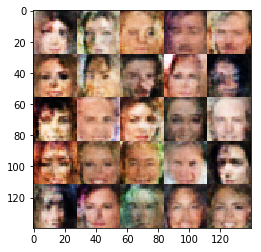

Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 1.9776
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.6828
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.5937
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.9196
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.7575
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 1.8001
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 2.2357


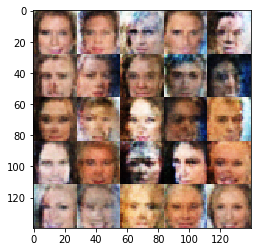

Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 2.4149
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.8408
Epoch 2/2... Discriminator Loss: 0.5620... Generator Loss: 2.1768
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.6164
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.7926
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.6258
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 2.1937
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 2.1917
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.6666


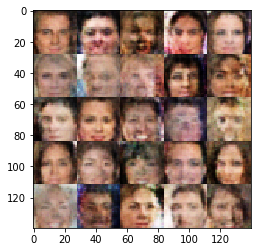

Epoch 2/2... Discriminator Loss: 0.5140... Generator Loss: 2.1304
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 1.5060
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 0.5207... Generator Loss: 1.9918
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 1.4470
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.3567


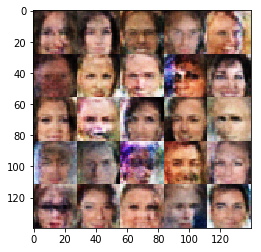

Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.6964
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.9097
Epoch 2/2... Discriminator Loss: 0.6489... Generator Loss: 1.9601
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.7719
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.5575
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 1.8275


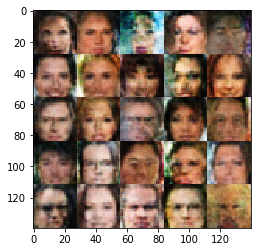

Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 2.0233
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.5843
Epoch 2/2... Discriminator Loss: 0.5166... Generator Loss: 2.2015
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 2.0078
Epoch 2/2... Discriminator Loss: 0.6470... Generator Loss: 2.4359
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.6490
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.6568


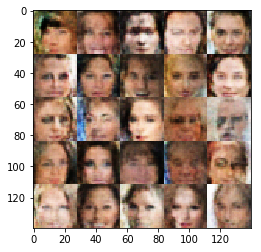

Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 1.7930
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.8922
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.3778
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 1.8516
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.4223
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.3780
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.4351
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.7828


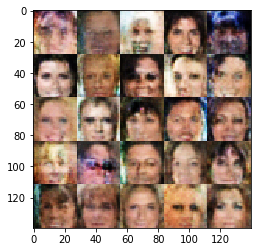

Epoch 2/2... Discriminator Loss: 0.4761... Generator Loss: 2.4378
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.3514
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 2.1947
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 2.1300
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 2.3118
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.2960


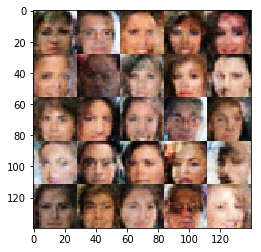

Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.8010
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.1817
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.8822
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 2.2114
Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 1.9723


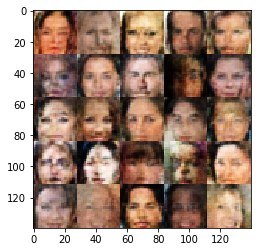

Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.5420
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.6928
Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 1.8216
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.7354
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 2.3519
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.6469
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.7415


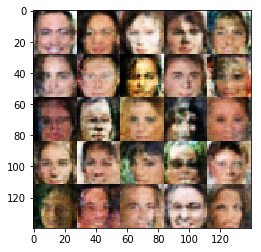

Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.1057... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 0.4971... Generator Loss: 2.2226
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 2.3914
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 1.7646
Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 1.6910


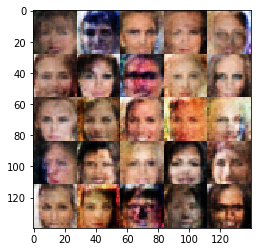

Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.8097
Epoch 2/2... Discriminator Loss: 0.5209... Generator Loss: 2.1300
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.7180
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 0.6748... Generator Loss: 1.4813
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.1568


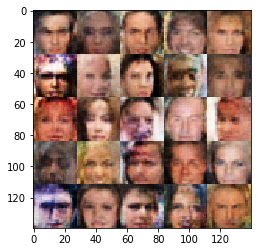

Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.9598
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 2.0124
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.9097
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.7789
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 2.0591
Epoch 2/2... Discriminator Loss: 0.5799... Generator Loss: 1.8363
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.3058
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.6451
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 1.5775


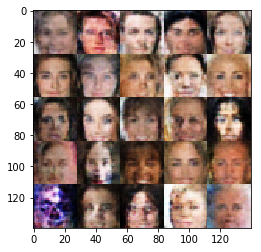

Epoch 2/2... Discriminator Loss: 0.6039... Generator Loss: 1.7078
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 2.6444
Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 0.7977... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 1.4005
Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 0.5425... Generator Loss: 2.2037
Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.5698


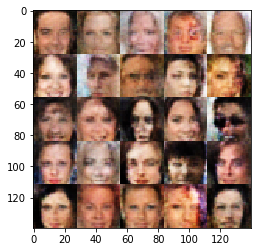

Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.0897
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 2.1804
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 2.5273
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 2.1312
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.4728


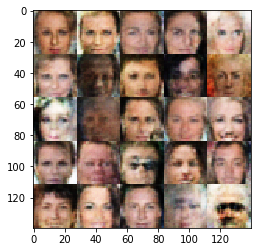

Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 1.3362
Epoch 2/2... Discriminator Loss: 0.5296... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 1.3424
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 2.1001
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.6042
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 1.7633
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 1.7802
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.6318... Generator Loss: 1.8127


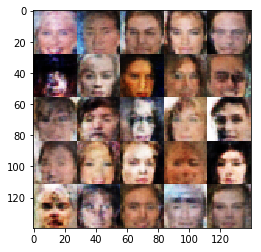

Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.2708
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.6376
Epoch 2/2... Discriminator Loss: 0.6730... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 3.2145
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.9144
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.8295
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 2.0026


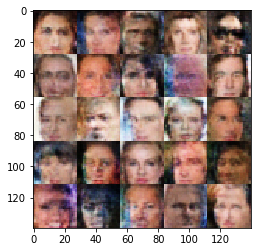

Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.1760
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.9119
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 1.9440
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 2.1735
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.7978
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.5925
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.4901
Epoch 2/2... Discriminator Loss: 0.5157... Generator Loss: 2.5275
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.8224


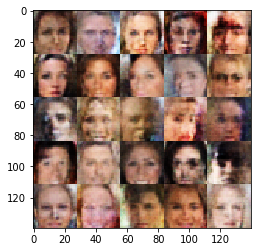

Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.8058
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 2.2480
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 2.0341
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 1.7939
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 2.5694
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.0498


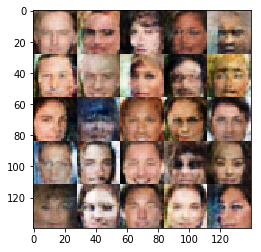

Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.8372
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.7244
Epoch 2/2... Discriminator Loss: 0.6421... Generator Loss: 1.7507
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 1.7038
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.1291
Epoch 2/2... Discriminator Loss: 0.6012... Generator Loss: 1.6439
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 2.0376
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.8228
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.7647
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 2.4770


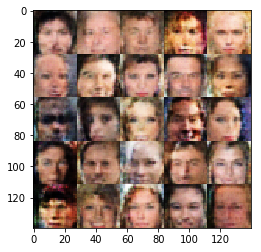

Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 1.4072
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 2.3401
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 1.7784
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.6403
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.9390
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.3928
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.1489


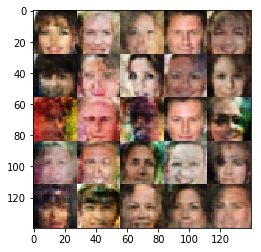

Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.7356
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.4067
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 2.0269
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 2.2025
Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 2.7564
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 0.5422... Generator Loss: 2.1364


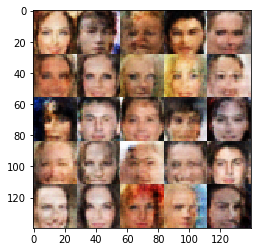

Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.8609
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.8909
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.2413
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 2.7539
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.3760
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.6649
Epoch 2/2... Discriminator Loss: 0.4609... Generator Loss: 2.5632
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.0101


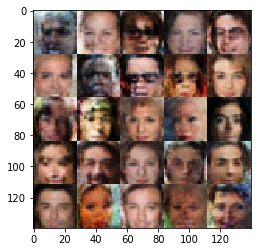

Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 2.0999
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 2.1239


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.